In [1]:
from dataman.audio_processing import *

import tensorflow as tf
from scipy.signal import spectrogram

In [31]:
data, labels = load_keystroke_data()
data

array([[  319,     1,  -309, ...,    -7,    -6,    -3],
       [ -232,   235,   858, ...,    -6,    -4,     1],
       [ -288,  -184,   -73, ...,    -8,    -9,    -7],
       ...,
       [ -971,  -102,   762, ...,   -12,   -10,    -1],
       [ -281,  -254,  -143, ...,     2,    -2,    -2],
       [ 1067,   466, -1349, ...,    15,     8,    -4]])

In [36]:
scaled_data = scale_keystroke_data(data)
scaled_data

array([[0.47384949, 0.45569259, 0.43799246, ..., 0.45523581, 0.45529291,
        0.4554642 ],
       [0.41767145, 0.43543418, 0.4591305 , ..., 0.42626754, 0.42634362,
        0.42653379],
       [0.39592253, 0.40652396, 0.41783894, ..., 0.42446483, 0.4243629 ,
        0.42456677],
       ...,
       [0.49726021, 0.51155979, 0.5257771 , ..., 0.51304076, 0.51307367,
        0.51322177],
       [0.39191961, 0.39745693, 0.42022149, ..., 0.44995898, 0.44913864,
        0.44913864],
       [0.59306971, 0.56609363, 0.48462678, ..., 0.54585035, 0.54553616,
        0.54499753]])

In [37]:
# 90% training, 10% testing
training_count = int(len(scaled_data) * 0.9)
x_train, x_test = scaled_data[:training_count], scaled_data[training_count:]
y_train, y_test = labels[:training_count], labels[training_count:]

In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(29, activation='softmax'),
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
3150/3150 [==============================] - 1s 368us/sample - loss: 3.5032 - accuracy: 0.0479
Epoch 2/5
3150/3150 [==============================] - 1s 295us/sample - loss: 3.3640 - accuracy: 0.0508
Epoch 3/5
3150/3150 [==============================] - 1s 310us/sample - loss: 3.3621 - accuracy: 0.0508
Epoch 4/5
3150/3150 [==============================] - 1s 311us/sample - loss: 3.3606 - accuracy: 0.0508
Epoch 5/5
350/350 [==============================] - 0s 311us/sample - loss: 3.3728 - accuracy: 0.0286


[3.3727880477905274, 0.028571429]

### Spectrogram Testing

/usr/local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Number of keystrokes detected in "/env/datasets/keystrokes/d/d-x.wav": 215
Drawing keystrokes...


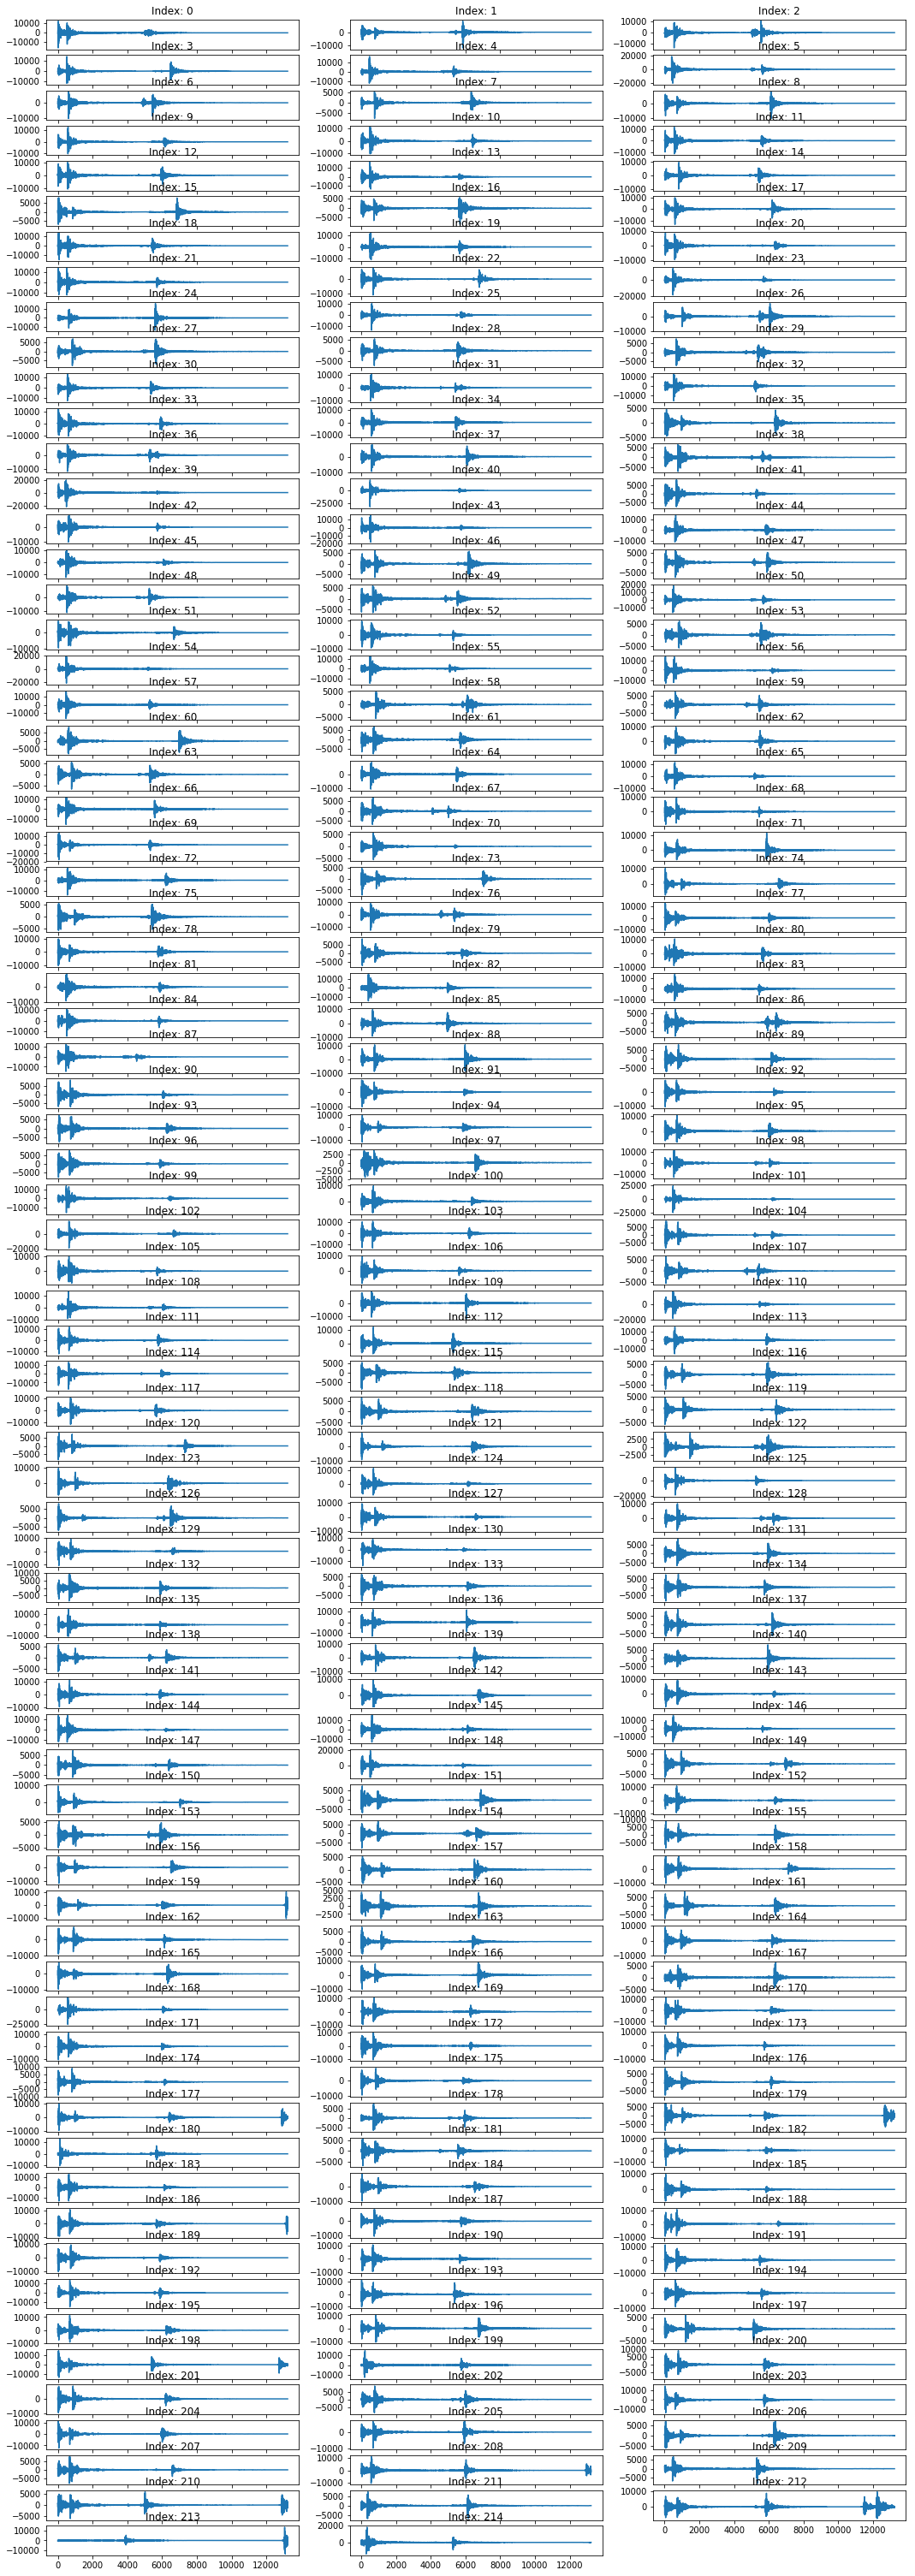

In [2]:
visualize_keystrokes('/env/datasets/keystrokes/d/d-x.wav')

In [ ]:
data = wav_read('/env/datasets/keystrokes/a/a-123x.wav')
keystrokes = extract_keystrokes(data)

In [ ]:
plt.specgram(keystrokes[0])

In [ ]:
plt.figure(figsize=(15, 13))
plt.subplot(2, 1, 1)
plt.plot(keystrokes[0])
plt.subplot(2, 1, 2)
plt.plot(ret[0])
plt.show()